<a href="https://colab.research.google.com/github/NINGTANG1124/UPF-HFI/blob/main/notebooks/modeling_chinese.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# connect to googledrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 合并 HFI 到建模数据表

In [3]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 120)

# 读取
survey_df = pd.read_excel( "/content/drive/MyDrive/UPF-HFI/Model/outcome/survey_with_HFI.xlsx")
df_upf    = pd.read_excel("/content/drive/MyDrive/UPF-HFI/Model/outcome/weighted_upf_percent.xlsx")

In [4]:
# ==== 2. 先检查 ====
issues = []

# 检查关键列
for col in ["UserID_clean", "HFI_binary", "HFI_raw_score"]:
    if col not in survey_df.columns:
        issues.append(f"survey 缺少 {col}")

for col in ["UserID_clean", "weighted_upf_percent"]:
    if col not in df_upf.columns:
        issues.append(f"upf 缺少 {col}")

# 检查 ID 是否有缺失/重复
for name, df in [("survey", survey_df), ("upf", df_upf)]:
    n_na = df["UserID_clean"].isna().sum()
    n_dup = df["UserID_clean"].duplicated().sum()
    if n_na:  issues.append(f"{name} 的 UserID_clean 有 {n_na} 个缺失")
    if n_dup: issues.append(f"{name} 的 UserID_clean 有 {n_dup} 个重复")

# 检查 upf_percent 是否数值
bad_upf = pd.to_numeric(df_upf["weighted_upf_percent"], errors="coerce").isna().sum()
if bad_upf:
    issues.append(f"weighted_upf_percent 有 {bad_upf} 个非数值/缺失")

# 打印检查结果
if issues:
    print("检查发现以下问题：")
    for i, msg in enumerate(issues, 1):
        print(f"{i}. {msg}")
else:
    print("没有发现问题，可以直接处理")


没有发现问题，可以直接处理


In [5]:
# ==== 检查关键变量缺失情况 ====
check_cols = ["HFI_binary", "weighted_upf_percent"]
missing_info = {}

for col in check_cols:
    if col not in survey_df.columns and col not in df_upf.columns:
        print(f"数据中找不到列: {col}")
        continue

    if col in survey_df.columns:
        n_miss = survey_df[col].isna().sum()
        missing_info[col] = n_miss
        print(f"{col} 在 survey_df 中缺失 {n_miss} 行")

    if col in df_upf.columns:
        n_miss = df_upf[col].isna().sum()
        missing_info[col] = n_miss
        print(f"{col} 在 upf_df 中缺失 {n_miss} 行")

# ==== 判断是否需要处理 ====
if all(v == 0 for v in missing_info.values()):
    print("两列都没有缺失，可以直接进入合并/建模")
else:
    print("存在缺失，需要处理后再合并")


HFI_binary 在 survey_df 中缺失 18 行
weighted_upf_percent 在 upf_df 中缺失 0 行
存在缺失，需要处理后再合并


In [6]:
# 1. 合并 survey 和 upf
df_model = pd.merge(survey_df, df_upf, on="UserID_clean", how="inner")

# 2. 删掉 HFI_binary 缺失的
df_model = df_model.dropna(subset=["HFI_binary"])

print("合并后样本量：", len(df_model))


合并后样本量： 308


In [7]:
# 导出合并后的数据
df_model.to_excel("/content/drive/MyDrive/UPF-HFI/Model/outcome/merged_model.xlsx", index=False)

print("已导出到 /content/drive/MyDrive/UPF-HFI/Model/outcome/merged_model.xlsx")


已导出到 /content/drive/MyDrive/UPF-HFI/Model/outcome/merged_model.xlsx


# 建模部分

## 步骤 0：一次性 dropna（主分析用的完整案例集）

In [8]:
# 1) 统一主分析变量清单（一次性 dropna）
all_vars = [
    "weighted_upf_percent","HFI_binary","income",
    "gender_participant","ethn_participant","age_participant",
    "child_numbers", "employ"
]
df_all = df_model[all_vars].apply(pd.to_numeric, errors="ignore").dropna().copy()
print("主分析样本量:", len(df_all))

# 这次是对所有 all_vars 里的变量做 完全案例（complete case）筛选，也就是任何一个变量缺失都会被剔除。因为 income、age_participant 等变量里可能有缺失，所以样本量从 308 → 305。

主分析样本量: 299


/tmp/ipython-input-668714713.py:7: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df_all = df_model[all_vars].apply(pd.to_numeric, errors="ignore").dropna().copy()


In [9]:
import pandas as pd

all_vars = ["weighted_upf_percent","HFI_binary","income",
    "gender_participant","ethn_participant","age_participant",
    "child_numbers", "employ"]

# 哪些列在 df_model 里缺失了多少？
print("每列缺失数：")
print(df_model[all_vars].isna().sum())

# 标出完全案例掩码
mask_complete = df_model[all_vars].notna().all(axis=1)

# 被 drop 的行 + 缺失列
dropped = df_model.loc[~mask_complete, ["UserID_clean"] + all_vars].copy()
dropped["missing_cols"] = dropped.apply(
    lambda r: [c for c in all_vars if pd.isna(r[c])], axis=1
)
print("\n被剔除的样本（以及缺失了哪些列）：")
print(dropped[["UserID_clean","missing_cols"]])


每列缺失数：
weighted_upf_percent    0
HFI_binary              0
income                  3
gender_participant      0
ethn_participant        0
age_participant         0
child_numbers           4
employ                  2
dtype: int64

被剔除的样本（以及缺失了哪些列）：
    UserID_clean     missing_cols
21        BFD041         [income]
38        BFD061         [employ]
95        BFD124  [child_numbers]
115       BFD151         [employ]
173       BFD220  [child_numbers]
189       BFD243         [income]
230       BFD295         [income]
272       BFD353  [child_numbers]
285       BFD371  [child_numbers]


## 步骤 1：检查“内部捣乱”变量（多重共线性 / VIF）

In [10]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

# One-hot 分类变量（drop_first避免虚拟变量陷阱）
vif_df = pd.get_dummies(df_all.drop(columns=["weighted_upf_percent"]), drop_first=True)

vif_results = pd.DataFrame({
    "Variable": vif_df.columns,
    "VIF": [variance_inflation_factor(vif_df.values, i) for i in range(vif_df.shape[1])]
}).sort_values("VIF", ascending=False)

print(vif_results)


             Variable       VIF
2  gender_participant  6.819030
4     age_participant  6.167936
5       child_numbers  5.821079
1              income  5.279584
3    ethn_participant  2.635621
6              employ  2.376755
0          HFI_binary  1.742598


你现在跑 VIF 检查的就是主分析用的那几个变量（df_all 里的），这样做是对的，因为 BMJ 主分析也是保证同一批自变量在五个模型里样本一致、可比性强。
如果你把所有可能变量都放进去跑 VIF，

一方面会混进不参与主分析的变量，
另一方面会因为缺失值多导致样本量骤减，不符合主分析的可比性原则。
所以VIF 检查只需要针对你要进 M1–M5 模型的自变量就可以，不用所有变量都跑。

所以你这个结果意味着：
没有达到“强共线性”的红线（10），可以保留全部变量
但 gender、age、income 三个变量有一定共线性，如果你做敏感性分析，可以尝试单独去掉其中一个，看结果是否稳定
换句话说，现在是安全可用的，直接进入 M1–M5 分析没问题。

## 步骤 2：主分析

In [11]:
print(df_all.columns.tolist())   # 应该包含 HFI_binary, income, gender_participant, ethn_participant, age_participant, child_numbers, employ, weighted_upf_percent


['weighted_upf_percent', 'HFI_binary', 'income', 'gender_participant', 'ethn_participant', 'age_participant', 'child_numbers', 'employ']


In [12]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf

# 一眼确认下列名是否都在
# print(df_all.columns.tolist())

forms_main = {
    "M1": "weighted_upf_percent ~ HFI_binary",
    "M2": "weighted_upf_percent ~ HFI_binary + income",
    "M3": "weighted_upf_percent ~ HFI_binary + income + C(gender_participant) + C(ethn_participant, Treatment(reference=1))",
    "M4": "weighted_upf_percent ~ HFI_binary + income + C(gender_participant) + C(ethn_participant, Treatment(reference=1)) + age_participant",
    "M5": "weighted_upf_percent ~ HFI_binary + income + C(gender_participant) + C(ethn_participant, Treatment(reference=1)) + age_participant + child_numbers",
    "M6": "weighted_upf_percent ~ HFI_binary + income + C(gender_participant) + C(ethn_participant, Treatment(reference=1)) + age_participant + child_numbers + C(employ)"
}

res = {k: smf.ols(v, data=df_all).fit(cov_type="HC3") for k,v in forms_main.items()}

print("Ns:", {k:int(m.nobs) for k,m in res.items()})  # 应该都一致


Ns: {'M1': 299, 'M2': 299, 'M3': 299, 'M4': 299, 'M5': 299, 'M6': 299}


In [13]:
rows=[]
for k in ["M1","M2","M3","M4","M5","M6"]:
    m = res[k]
    b  = m.params["HFI_binary"]
    lo, hi = m.conf_int().loc["HFI_binary"]
    p  = m.pvalues["HFI_binary"]
    rows.append([k, b, lo, hi, p, int(m.nobs), m.rsquared])

main_tbl = (pd.DataFrame(rows, columns=["Model","HFI_coef_pp","CI_low","CI_high","p","N","R2"])
              .round({"HFI_coef_pp":2,"CI_low":2,"CI_high":2,"p":4,"R2":3}))
print(main_tbl)

main_tbl.to_excel("out_main_M1_M6.xlsx", index=False)


  Model  HFI_coef_pp  CI_low  CI_high       p    N     R2
0    M1         2.27   -0.67     5.20  0.1299  299  0.008
1    M2         2.57   -0.64     5.79  0.1168  299  0.008
2    M3         3.37    0.15     6.60  0.0403  299  0.077
3    M4         3.25    0.03     6.47  0.0478  299  0.090
4    M5         3.06   -0.23     6.34  0.0681  299  0.094
5    M6         3.32   -0.00     6.64  0.0503  299  0.123


/tmp/ipython-input-3923352802.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(
/tmp/ipython-input-3923352802.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["No HFI", "HFI"])


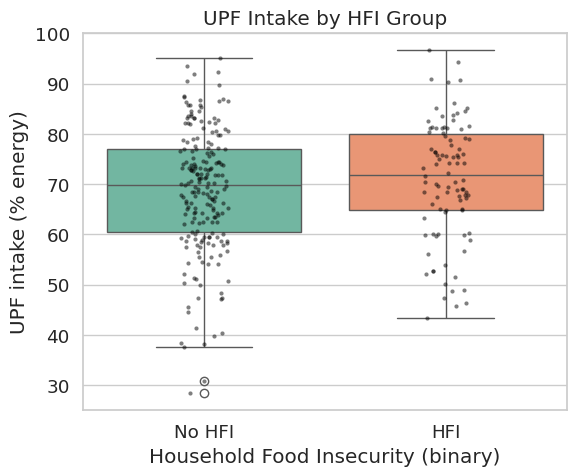

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# 设置画图风格
sns.set(style="whitegrid", font_scale=1.2)

plt.figure(figsize=(6, 5))
ax = sns.boxplot(
    data=df_all,
    x="HFI_binary",
    y="weighted_upf_percent",
    palette=["#66c2a5", "#fc8d62"]
)
ax = sns.stripplot(
    data=df_all,
    x="HFI_binary",
    y="weighted_upf_percent",
    color="black",
    size=3,
    alpha=0.5
)

# 坐标轴 & 标题
ax.set_xticklabels(["No HFI", "HFI"])
ax.set_xlabel("Household Food Insecurity (binary)")
ax.set_ylabel("UPF intake (% energy)")
ax.set_title("UPF Intake by HFI Group")

plt.tight_layout()
plt.show()


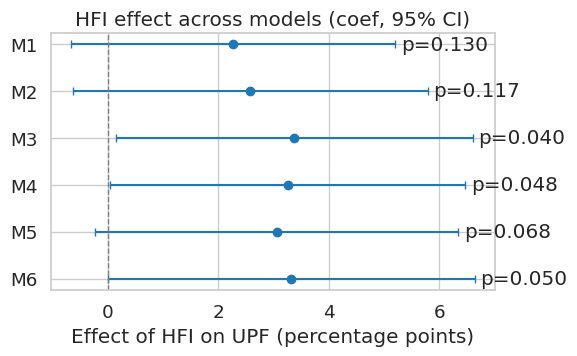

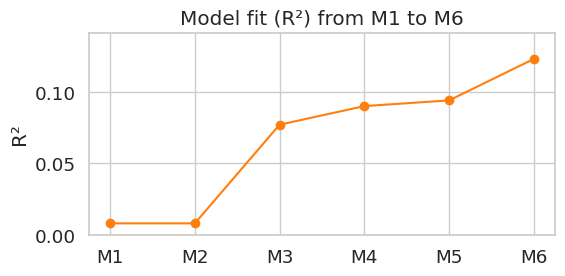

In [15]:
# ================= 可视化 HFI 系数 & 模型 R² =================

import numpy as np
import matplotlib.pyplot as plt

# 确保 M1..M6 按顺序排列
mt = main_tbl.copy()
mt["Model_num"] = mt["Model"].str.extract(r"M(\d+)").astype(int)
mt = mt.sort_values("Model_num")

# --- 图 A：HFI 系数（pp）变化 ---
y = np.arange(len(mt))[::-1]

fig, ax = plt.subplots(figsize=(6, 3.8))
ax.errorbar(
    mt["HFI_coef_pp"], y,
    xerr=[mt["HFI_coef_pp"] - mt["CI_low"], mt["CI_high"] - mt["HFI_coef_pp"]],
    fmt='o', capsize=3, color='tab:blue'
)
ax.axvline(0, ls='--', lw=1, color='gray')
ax.set_yticks(y)
ax.set_yticklabels(mt["Model"])
ax.set_xlabel("Effect of HFI on UPF (percentage points)")
ax.set_title("HFI effect across models (coef, 95% CI)")

# 在右侧标注 p 值
for i, p in enumerate(mt["p"]):
    ax.text(mt["CI_high"].iloc[i] + 0.1, y[i], f"p={p:.3f}", va='center')

plt.tight_layout()
plt.show()

# --- 图 B：R² 随模型变化 ---
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(mt["Model"], mt["R2"], marker='o', color='tab:orange')
ax.set_ylim(0, max(mt["R2"]) * 1.15)
ax.set_ylabel("R²")
ax.set_title("Model fit (R²) from M1 to M6")
plt.tight_layout()
plt.show()


## M7：交互（换成可读标签，便于解释与作图）

In [28]:
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from statsmodels.graphics.factorplots import interaction_plot
import pandas as pd

# ==============================
# Step 0: 合并稀疏族裔
# ==============================
ethn_counts = df_model["ethn_label"].value_counts()
small_ethn = ethn_counts[ethn_counts < 10].index
df_model["ethn_label"] = df_model["ethn_label"].replace(small_ethn, "Other ethnic group")

# 重新编码 ethn_participant 保持和 ethn_label 一致
ethn_mapping = {label: i+1 for i, label in enumerate(df_model["ethn_label"].unique())}
df_model["ethn_participant"] = df_model["ethn_label"].map(ethn_mapping)

# income_label 保持原来
income_labels = {
    1: "<£10k",
    2: "£10–20k",
    3: "£20–30k",
    4: "£30–40k",
    5: "£40–50k",
    6: "£50–60k",
    7: "£60–70k",
    8: ">£70k"
}
df_model["income_label"] = df_model["income"].map(income_labels)

df_model["ethn_label"] = pd.Categorical(df_model["ethn_label"], categories=df_model["ethn_label"].unique())
df_model["income_label"] = pd.Categorical(df_model["income_label"], categories=list(income_labels.values()))

y = "weighted_upf_percent"


In [33]:
# ---------- 准备：确保可视化用到的分组是字符串 ----------
df_model = df_model.copy()
df_model["HFI_plot"]  = df_model["HFI_binary"].map({0:"Food secure", 1:"Food insecure"}).astype(str)
df_model["ethn_label"] = df_model["ethn_label"].astype(str)   # 若之前是Categorical，转成str更稳
df_plot = df_model.dropna(subset=[y, "HFI_binary", "ethn_label"]).copy()
df_plot["ethn_plot"] = df_plot["ethn_label"].astype(str)

# ---------- 小工具函数 ----------
def fit_robust_HC3(formula, data):
    """两步拟合：先 OLS，再替换为 HC3 协方差；返回 (ols, robust, 结果表)"""
    ols = smf.ols(formula=formula, data=data).fit()
    robust = ols.get_robustcov_results(cov_type="HC3", use_t=True)
    ci = robust.conf_int()
    table = pd.DataFrame({
        "coef": robust.params,
        "se(HC3)": robust.bse,
        "t": robust.tvalues,
        "p": robust.pvalues,
        "ci_low": ci[:,0],
        "ci_high": ci[:,1],
    })
    return ols, robust, table

def mode(series):
    return series.mode().iloc[0]

def plot_margins_2way(model, data, factor, by, title,
                      hold_income=None, hold_ethn=None):
    """
    绘制二元交互的预测均值±95%CI
    factor: x 轴分组（str），by: HFI_plot（或其它二水平因子）的字符串列
    hold_income: 预测时固定的 income 值（int），若为空取中位数
    hold_ethn:   预测时固定的 ethn_label 值（str），若为空取 baseline
    """
    # 固定其他协变量为样本代表值
    age0   = data["age_participant"].mean()
    child0 = data["child_numbers"].mean()
    inc0   = int(np.round(data["income"].median())) if hold_income is None else int(hold_income)
    gender0 = mode(data["gender_participant"])
    employ0 = mode(data["employ"])

    # 若需要固定某个族裔
    ethn0 = hold_ethn if hold_ethn is not None else "White British"

    # 预测网格
    levels_x  = list(pd.Series(data[factor].dropna().unique()).astype(str).sort_values())
    levels_by = list(pd.Series(data[by].dropna().unique()).astype(str))

    rows = []
    for bx in levels_by:       # e.g., Food secure vs Food insecure
        for lv in levels_x:
            row = {
                "HFI_binary": 1 if bx == "Food insecure" else 0,
                "income": inc0,
                "age_participant": age0,
                "child_numbers": child0,
                "gender_participant": gender0,
                "employ": employ0,
                "ethn_label": lv if factor=="ethn_label" else ethn0
            }
            rows.append(row)
    new = pd.DataFrame(rows)

    # 预测（使用稳健协方差）
    pred = model.get_prediction(new).summary_frame(alpha=0.05)  # 使用 robustcov 后也能给出线性预测CI
    new["pred"] = pred["mean"]
    new["ci_low"] = pred["mean_ci_lower"]
    new["ci_high"] = pred["mean_ci_upper"]
    new[factor] = np.repeat(levels_x, len(levels_by))
    new[by]     = np.tile(levels_by, len(levels_x))

    # 画图
    plt.figure(figsize=(10,6))
    for bx in levels_by:
        sub = new[new[by]==bx]
        plt.errorbar(sub[factor], sub["pred"],
                     yerr=[sub["pred"]-sub["ci_low"], sub["ci_high"]-sub["pred"]],
                     fmt='o-', capsize=3, label=bx)
    plt.title(title)
    plt.ylabel("Predicted UPF% (±95% CI)")
    plt.xticks(rotation=45)
    plt.legend(title=by)
    plt.tight_layout()
    plt.show()

M7 (HC3) results:


,coef,se(HC3),t,p,ci_low,ci_high
0,66.722747,3.689143,18.086246,8.144421e-49,59.460429,73.985065
1,-9.802713,4.924526,-1.990590,4.750848e-02,-19.496962,-0.108463
2,-5.744653,2.964503,-1.937813,5.366221e-02,-11.580470,0.091164
3,-6.091345,4.154978,-1.466035,1.437729e-01,-14.270690,2.087999
4,-1.961331,3.746922,-0.523451,6.010788e-01,-9.337390,5.414728
5,-6.283368,2.340602,-2.684510,7.701353e-03,-10.890995,-1.675741
6,0.166616,1.488250,0.111954,9.109409e-01,-2.763102,3.096333
7,-3.315845,4.350811,-0.762121,4.466361e-01,-11.880700,5.249009
8,-6.951587,58.710575,-0.118404,9.058331e-01,-122.527173,108.623998
9,-1.828852,6.075940,-0.300999,7.636410e-01,-13.789735,10.132031


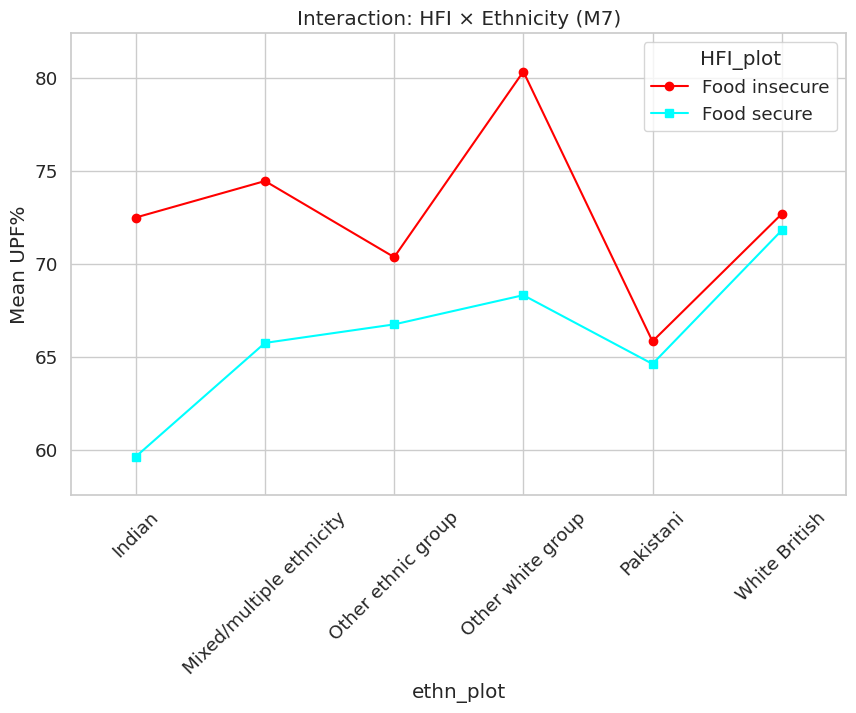

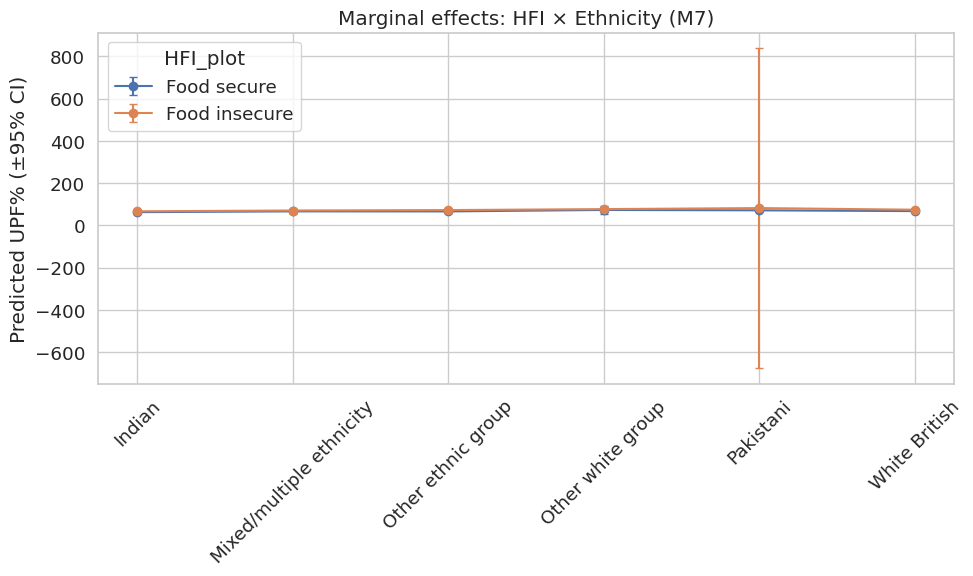

In [34]:
# M7: HFI × Ethnicity
# ==============================
form_m7 = (
    f"{y} ~ HFI_binary * C(ethn_label, Treatment(reference='White British'))"
    " + income + C(gender_participant) + age_participant + child_numbers + C(employ)"
)
m7_ols, m7, m7_tbl = fit_robust_HC3(form_m7, df_model)
print("M7 (HC3) results:")
display(m7_tbl)

# 快速均值趋势
fig, ax = plt.subplots(figsize=(10, 6))
interaction_plot(df_plot["ethn_plot"], df_plot["HFI_plot"], df_plot[y],
                 markers=["o","s"], ax=ax)
ax.set_title("Interaction: HFI × Ethnicity (M7)")
ax.set_ylabel("Mean UPF%")
plt.xticks(rotation=45); plt.show()

# 边际效应 + 95%CI（按族裔×HFI）
plot_margins_2way(m7, df_model, factor="ethn_label", by="HFI_plot",
                  title="Marginal effects: HFI × Ethnicity (M7)")


M8 (HC3) results:


,coef,se(HC3),t,p,ci_low,ci_high
0,65.136309,4.132017,15.763803,1.513948e-40,57.002672,73.269945
1,0.457088,1.466294,0.311730,7.554766e-01,-2.429227,3.343403
2,-5.819310,5.330040,-1.091795,2.758585e-01,-16.311185,4.672565
3,-3.193927,2.522635,-1.266107,2.065233e-01,-8.159588,1.771734
4,-4.633916,2.273060,-2.038625,4.242339e-02,-9.108302,-0.159530
5,-0.633971,3.574538,-0.177358,8.593553e-01,-7.670241,6.402299
6,-6.413972,1.941314,-3.303933,1.076985e-03,-10.235337,-2.592608
7,-3.103378,4.465184,-0.695017,4.876191e-01,-11.892834,5.686078
8,-6.245970,42.718937,-0.146211,8.838598e-01,-90.335724,77.843784
9,-2.414223,5.682301,-0.424867,6.712587e-01,-13.599503,8.771058


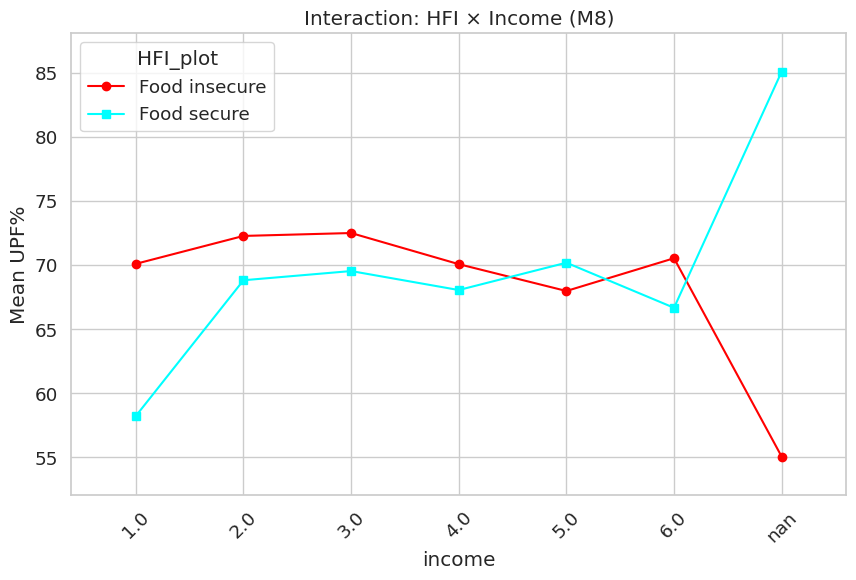

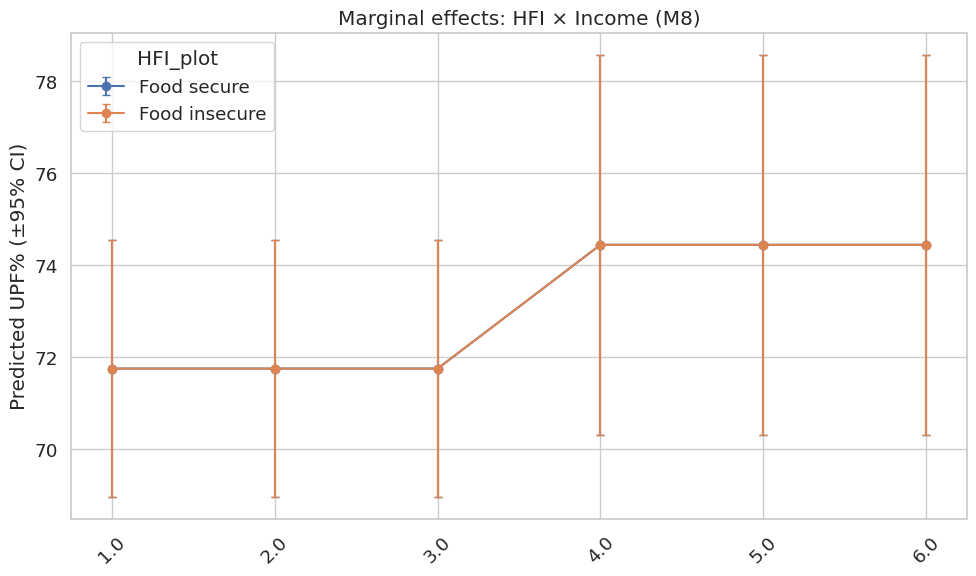

In [35]:
# M8: HFI × Income
# ==============================
form_m8 = (
    f"{y} ~ HFI_binary * income"
    " + C(gender_participant) + C(ethn_label, Treatment(reference='White British'))"
    " + age_participant + child_numbers + C(employ)"
)
m8_ols, m8, m8_tbl = fit_robust_HC3(form_m8, df_model)
print("M8 (HC3) results:")
display(m8_tbl)

# 快速均值趋势（income 转字符串只是用于画图分组）
fig, ax = plt.subplots(figsize=(10, 6))
interaction_plot(df_plot["income"].astype(str), df_plot["HFI_plot"], df_plot[y],
                 markers=["o","s"], ax=ax)
ax.set_title("Interaction: HFI × Income (M8)")
ax.set_ylabel("Mean UPF%")
plt.xticks(rotation=45); plt.show()

# 边际效应 + 95%CI（按收入×HFI；族裔固定在 White British）
plot_margins_2way(m8, df_model, factor="income", by="HFI_plot",
                  title="Marginal effects: HFI × Income (M8)",
                  hold_ethn="White British")


M9 (HC3) results:


,coef,se(HC3),t,p,ci_low,ci_high
0,65.206155,4.179251,15.602356,8.835525e-40,56.978898,73.433413
1,-10.305981,4.985320,-2.067266,3.964125e-02,-20.120063,-0.491899
2,-5.782763,2.966842,-1.949130,5.229276e-02,-11.623278,0.057753
3,-5.892798,4.230562,-1.392911,1.647675e-01,-14.221067,2.435471
4,-1.508402,3.899498,-0.386819,6.991879e-01,-9.184940,6.168136
5,-6.152851,2.363408,-2.603381,9.730301e-03,-10.805447,-1.500254
6,0.216539,1.492503,0.145085,8.847499e-01,-2.721597,3.154676
7,-3.422492,4.334542,-0.789586,4.304475e-01,-11.955456,5.110471
8,-6.606392,77.367781,-0.085389,9.320137e-01,-158.912324,145.699540
9,-1.954807,5.943446,-0.328901,7.424797e-01,-13.655053,9.745439


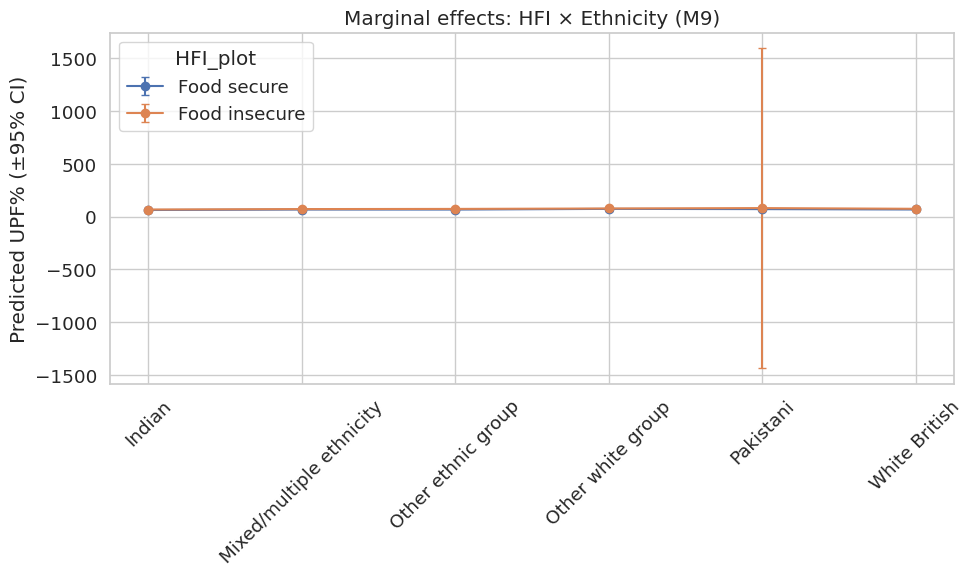

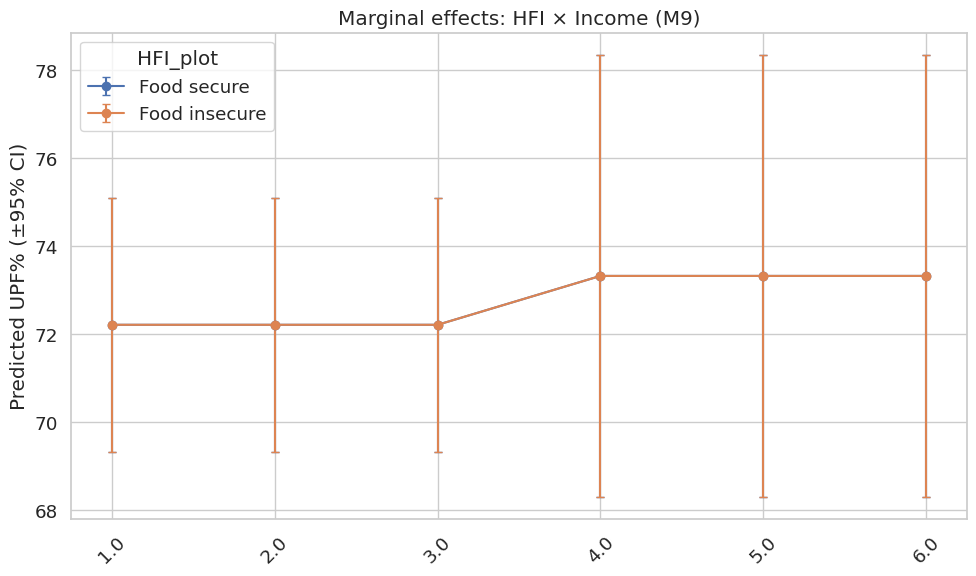

In [36]:
# M9: HFI × Income + HFI × Ethnicity
# ==============================
form_m9 = (
    f"{y} ~ HFI_binary * income"
    " + HFI_binary * C(ethn_label, Treatment(reference='White British'))"
    " + C(gender_participant) + age_participant + child_numbers + C(employ)"
)
m9_ols, m9, m9_tbl = fit_robust_HC3(form_m9, df_model)
print("M9 (HC3) results:")
display(m9_tbl)

# 边际效应 + 95%CI（两张图：固定收入；固定族裔）
# 1) 固定收入在样本中位数，展示 族裔×HFI
plot_margins_2way(m9, df_model, factor="ethn_label", by="HFI_plot",
                  title="Marginal effects: HFI × Ethnicity (M9)",
                  hold_income=int(np.round(df_model["income"].median())))
# 2) 固定族裔为 White British，展示 收入×HFI
plot_margins_2way(m9, df_model, factor="income", by="HFI_plot",
                  title="Marginal effects: HFI × Income (M9)",
                  hold_ethn="White British")

# 敏感性分析

In [18]:
print(df_model.columns)


Index(['record_id', 'redcap_survey_identifier', 'screening_timestamp',
       'contin', 'age_1', 'sex_1', 'ethnicity_1', 'ethnicityother_1',
       'otherchild_1', 'age_2',
       ...
       'HFI_raw_score', 'HFI_category', 'HFI_binary', 'weekday_kcal',
       'weekend_kcal', 'weekday_upf_kcal', 'weekend_upf_kcal', 'weighted_kcal',
       'weighted_upf_kcal', 'weighted_upf_percent'],
      dtype='object', length=123)


In [19]:
# === 三分类 HFI 敏感性分析（一次输出 Wald + 趋势）===

import numpy as np
import pandas as pd
import statsmodels.formula.api as smf

# 结局变量
y = "weighted_upf_percent"

# 保证三分类列存在且有序
df_sens = df_model.copy()
cat_dtype = pd.api.types.CategoricalDtype(
    categories=["Food secure", "Low food security", "Very low food security"],
    ordered=True
)
df_sens["HFI_category"] = df_sens["HFI_category"].astype(cat_dtype)

# —— 与主分析一致的“全控”模型（M6） ——
form_full = (
    f"{y} ~ C(HFI_category, Treatment(reference='Food secure'))"
    " + income + C(gender_participant)"
    " + C(ethn_participant, Treatment(reference=1))"
    " + age_participant + child_numbers + C(employ)"
)

# 完整案例（一次 dropna，保证 N 一致）
need_cols = [y,"HFI_category","income","gender_participant","ethn_participant",
             "age_participant","child_numbers","employ"]
dat = df_sens[need_cols].dropna().copy()
print("N used:", len(dat))

# 拟合 OLS + HC3
m_full = smf.ols(form_full, data=dat).fit(cov_type="HC3")

# —— (1) Wald 联合显著性检验：HFI 三分类整体 ——
idx = [i for i, nm in enumerate(m_full.params.index)
       if nm.startswith("C(HFI_category, Treatment(reference='Food secure'))[T.")]
if idx:
    R = np.eye(len(m_full.params))[idx]
    wald_p = float(m_full.wald_test(R, use_f=False).pvalue)
else:
    wald_p = np.nan

# —— (2) 线性趋势检验：把三分类编码为 0,1,2 ——
dat["HFI_trend"] = dat["HFI_category"].cat.codes  # Food=0, Low=1, VeryLow=2
form_trend = (
    f"{y} ~ HFI_trend + income + C(gender_participant)"
    " + C(ethn_participant, Treatment(reference=1))"
    " + age_participant + child_numbers + C(employ)"
)
m_trend = smf.ols(form_trend, data=dat).fit(cov_type="HC3")
trend_b  = float(m_trend.params["HFI_trend"])
trend_ci = m_trend.conf_int().loc["HFI_trend"].tolist()
trend_p  = float(m_trend.pvalues["HFI_trend"])

# —— 摘要输出（便于论文引用）——
print("\n=== Sensitivity: HFI 3-category (vs Food secure) ===")
print(f"Wald (overall) p = {wald_p:.4f}")
print(f"Linear trend: β = {trend_b:.2f} pp "
      f"(95% CI {trend_ci[0]:.2f}, {trend_ci[1]:.2f}), p = {trend_p:.4f}")
print(f"R^2 (full model) = {m_full.rsquared:.3f}")

# 如需保存成表：
# pd.DataFrame({
#     "N":[len(dat)],
#     "Wald_p":[wald_p],
#     "Trend_beta":[trend_b],
#     "Trend_CI_l":[trend_ci[0]],
#     "Trend_CI_h":[trend_ci[1]],
#     "Trend_p":[trend_p],
#     "R2":[m_full.rsquared]
# }).to_excel("sensitivity_HFI_3cat_summary.xlsx", index=False)


N used: 299

=== Sensitivity: HFI 3-category (vs Food secure) ===
Wald (overall) p = 0.0406
Linear trend: β = 2.55 pp (95% CI 0.52, 4.59), p = 0.0139
R^2 (full model) = 0.130


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(


主分析（HFI 二分类）和敏感性分析（三分类）方向一致——HFI 越不安全，UPF 百分比越高。

三分类整体效应（Wald p = 0.0406）显著，趋势检验（p = 0.0139）也显著，方向为 正（β = 2.55 pp），和二分类结果是一致的。

置信区间 (0.52, 4.59) 全部在正方向，没有跨 0。

唯一的区别是：
样本量（299）比主分析小，导致显著性略弱（p 值大一些），但这在敏感性分析中是正常的，因为换分类会丢掉一些信息。
这在论文里完全可以写成——敏感性分析验证了结果稳健。

In [21]:
# 打印 M1–M6 主分析结果
print(main_tbl)

# 打印 M7 交互分析结果
print(effects_df)

# 打印三分类敏感性分析结果
print(f"Wald p (overall) = {wald_p:.4f}")
print(f"Linear trend: β = {trend_b:.2f} pp (95% CI {trend_ci[0]:.2f}, {trend_ci[1]:.2f}), p = {trend_p:.4f}")


  Model  HFI_coef_pp  CI_low  CI_high       p    N     R2
0    M1         2.27   -0.67     5.20  0.1299  299  0.008
1    M2         2.57   -0.64     5.79  0.1168  299  0.008
2    M3         3.37    0.15     6.60  0.0403  299  0.077
3    M4         3.25    0.03     6.47  0.0478  299  0.090
4    M5         3.06   -0.23     6.34  0.0681  299  0.094
5    M6         3.32   -0.00     6.64  0.0503  299  0.123
                                           eth_group  effect      lo      hi
0                                White British (ref)    1.73   -2.95    6.41
1                                  Other white group   11.65 -164.14  187.45
2                                          Pakistani    1.44   -4.87    7.75
3                                             Indian   10.95  -11.86   33.76
4                                        Bangladeshi   -1.73  -18.24   14.77
5                                  Other Asian group    6.33    0.35   12.31
6                           Mixed/multiple ethnicity   